### Linear Dynamical System


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta
from scipy.linalg import solve_triangular, solve
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression, PrincipalComponentRegression, RandomizedReducedRankRegression
from DynamicalSystems.kernels import Linear, Quadratic, RBF, Matern
from DynamicalSystems.utils import modified_norm_sq, modified_QR,lsp, plot_eigs, IterInv

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
d=100
r = 5
Q = np.random.randn(d,r)
Q, _ = np.linalg.qr(Q)
D = 1 - np.random.rand(r)
D = np.diag(D)# /D.max())
M = Q@D@Q.T

def linear_map(x, sigma =0.1):
    return M @ x + sigma*np.random.randn(*x.shape)

def lds(x0,n, sigma = 0.1):
    x = np.empty((n,d),dtype=np.float64)
    x[0] = x0
    for t in range(1,n):
        x[t] = linear_map(x[t-1], sigma = sigma)
    return x


In [3]:
#kernel = Matern(nu=0.5, length_scale=0.5)
kernel = Linear(coef0=0.)
rank = 5
sigma = 0.1
#estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression, RandomizedReducedRankRegression]
#estimators = [ReducedRankRegression,RandomizedReducedRankRegression]
estimators = [PrincipalComponentRegression, RandomizedReducedRankRegression, KernelRidgeRegression]
estimators = [KernelRidgeRegression]
train_max = 200
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 10
test_X = np.random.randn(test_size,d, test_repetitions)
test_Y = np.empty_like(test_X)

for i in range(test_repetitions):
    test_Y[:,:,i] = linear_map(test_X[:,:,i].T).T

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        X = np.random.randn(train_size,d)
        Y = linear_map(X.T, sigma = sigma).T
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
            #e = estimator(kernel)
        else:
            e = estimator(kernel, rank, tikhonov_reg=None)
            e = estimator(kernel, rank)
        if estimator == RandomizedReducedRankRegression:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg, powers=1)
            #e = estimator(kernel, rank, powers=3)
        e.fit(X, Y, backend='keops')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,:,k], test_Y[:,:,k])

KernelRidgeRegression:   0%|          | 0/10 [00:00<?, ?it/s]

(20, 100)


RuntimeError: [KeOps] Wrong value of the 'j' dimension 0 for arg at position 3 : is -2084749939 but was -7779320 in previous 'j' arguments.

In [6]:
e.K_X.shape

(20, 20)

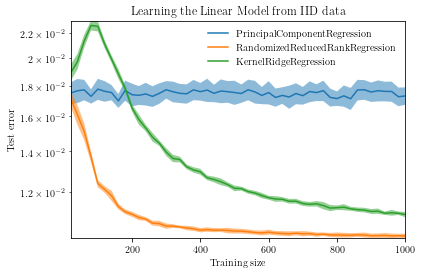

In [ ]:
for idx, estimator in enumerate(estimators):
    mean = np.mean(errors[:,:,idx], axis = 1)
    std = np.std(errors[:,:,idx], axis = 1)
    plt.fill_between(train_sizes, mean - std, mean + std, alpha = 0.5)
    plt.plot(train_sizes, mean, '-', label = estimator.__name__)
plt.margins(0)
plt.legend(frameon=False)
plt.ylabel("Test error")
plt.xlabel("Training size")
plt.title("Learning the Linear Model from IID data")
plt.savefig("figs/logistic_map_error.pdf")
plt.yscale('log')

In [ ]:
#kernel = Matern(nu=0.5, length_scale=0.5)
kernel = Linear(coef0=0.)
rank = 5
estimators = [PrincipalComponentRegression, RandomizedReducedRankRegression, KernelRidgeRegression]
train_max = 1000
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 10
offset = 500
sigma = 0.05

test_X = np.random.randn(test_size,d, test_repetitions)
test_Y = np.empty((test_size,d, test_repetitions), dtype = np.float64) 

for k in range(test_repetitions):
    test_data = lds(np.ones(d,dtype=np.float64), offset + test_size+1,  sigma= sigma)
    test_X[:,:,k] = test_data[offset:-1]
    test_Y[:,:,k] = test_data[offset+1:]

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        data = lds(np.ones(d,dtype=np.float64), offset + train_size +1,  sigma= sigma)
        X = data[offset:-1]
        Y = data[offset+1:]
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
            #e = estimator(kernel, rank)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,:,k], test_Y[:,:,k])

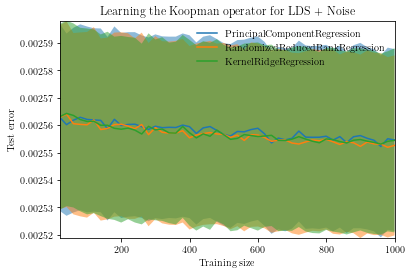

In [15]:
for idx, estimator in enumerate(estimators):
    mean = np.mean(errors[:,:,idx], axis = 1)
    std = np.std(errors[:,:,idx], axis = 1)
    plt.fill_between(train_sizes, mean - std, mean + std, alpha = 0.5)
    plt.plot(train_sizes, mean, '-', label = estimator.__name__)
plt.margins(0)
plt.legend(frameon=False)
plt.ylabel("Test error")
plt.xlabel("Training size")
plt.title("Learning the Koopman operator for LDS + Noise")
plt.savefig("figs/logistic_map_error.pdf")